In [3]:
pip install faiss-cpu

     |████████████████████████████████| 8.5 MB 1.6 MB/s eta 0:00:01     |███████████████████▍            | 5.2 MB 1.6 MB/s eta 0:00:03
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import faiss
from matplotlib import pyplot as plt




In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Defining 50 layer residual network : ResNet50 trained on million images, to get features for our dataset.
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [7]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/home/pranali/Downloads/input_Images'
filenames = sorted(get_file_list(root_dir))

In [8]:
import glob
img_lst = []
image_paths = glob.glob('/home/pranali/Downloads/input_Images/*.jpg')
for image_path in image_paths:
    img_lst.append(image_path)

In [9]:
imglist = img_lst[:500]

In [10]:
feature_list = []
for i in tqdm(range(len(imglist))):
    feature_list.append(extract_features(imglist[i], model))

100%|█████████████████████████████████████████| 500/500 [01:06<00:00,  7.48it/s]


In [11]:
features=np.array(feature_list)
features.shape

(500, 100352)

In [12]:
dimensions=features.shape[1]
db_vectors=features 
nlist = 1  # number of clusters
quantiser = faiss.IndexFlatL2(dimensions) #to assign the vectors to a particular cluster. This is index that uses the L2 distance metric 
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) #defining index

In [13]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)

False
0
True
500


In [14]:
nprobe = 1  # find 2 most similar clusters
n_query = 1000  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
#Trying out a random images at 23rd position in images folder :
distances, indices = index.search(features, k)

In [15]:
distances

array([[0.        , 0.65736777, 0.6928428 , ..., 0.788034  , 0.79133517,
        0.79940087],
       [0.        , 0.775795  , 0.83846927, ..., 0.87020767, 0.8752061 ,
        0.8786971 ],
       [0.        , 0.9950119 , 1.0314281 , ..., 1.1159875 , 1.1382169 ,
        1.1588702 ],
       ...,
       [0.        , 0.5767978 , 0.59222114, ..., 0.73828596, 0.7388378 ,
        0.73947954],
       [0.        , 0.6312772 , 0.67682606, ..., 0.7884575 , 0.789519  ,
        0.7903625 ],
       [0.        , 0.7231885 , 0.728513  , ..., 0.8480393 , 0.8566417 ,
        0.87968   ]], dtype=float32)

In [16]:
indices

array([[  0, 456,  74, ..., 419, 163, 302],
       [  1, 151, 195, ...,  16,  57, 216],
       [  2, 355, 489, ..., 333, 198, 446],
       ...,
       [497, 369, 122, ..., 325,  46, 198],
       [498, 356, 266, ..., 122, 258,  46],
       [499, 431, 199, ..., 479, 459,  24]])

In [17]:
def faiss_similarity(img):
    feature_list=extract_features('/home/pranali/Downloads/input_Images/'+str(img), model)
    nprobe = 2  # find 2 most similar clusters
    n_query = 1  
    k = 10  # return 10 nearest neighbours
    np.random.seed(0)
    dimensions=len(feature_list)   
    query_vectors = np.random.random((n_query, dimensions)).astype('float32')
    distances, indices = index.search(feature_list.reshape(1,-1), k)
    list_ind=indices.flatten().tolist()
    f, ax = plt.subplots(1, 10, figsize=(16, 8))
    for i,j in enumerate(list_ind):
        ax[i].imshow(plt.imread(imglist[j]))
        ax[i].set_axis_off()
    plt.show()

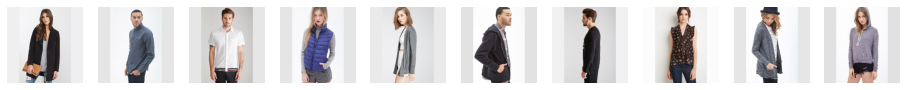

In [18]:
faiss_similarity('MEN_Jackets_Vests_id_0000008404_1_front.jpg')

In [19]:
imglist2 = []
for i in range(len(imglist)):
    imglist2.append(imglist[i])
print(len(imglist2))
print(imglist2)

500
['/home/pranali/Downloads/input_Images/WOMEN_Dresses_id_0000499601_2_side.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Blouses_Shirts_id_0000341406_2_side.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Tees_Tanks_id_0000242208_3_back.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Dresses_id_0000322202_7_additional.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Blouses_Shirts_id_0000118001_7_additional.jpg', '/home/pranali/Downloads/input_Images/MEN_Pants_id_0000249306_1_front.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Tees_Tanks_id_0000426903_1_front.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Tees_Tanks_id_0000668602_2_side.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Blouses_Shirts_id_0000035406_1_front.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Cardigans_id_0000530401_3_back.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Jackets_Coats_id_0000084201_1_front.jpg', '/home/pranali/Downloads/input_Images/WOMEN_Tees_Tanks_id_0000082905_2_side.

In [20]:
df_img = pd.DataFrame()
df_img['img'] = imglist2
df_img

,img
0,/home/pranali/Downloads/input_Images/WOMEN_Dre...
1,/home/pranali/Downloads/input_Images/WOMEN_Blo...
2,/home/pranali/Downloads/input_Images/WOMEN_Tee...
3,/home/pranali/Downloads/input_Images/WOMEN_Dre...
4,/home/pranali/Downloads/input_Images/WOMEN_Blo...
...,...
495,/home/pranali/Downloads/input_Images/WOMEN_Tee...
496,/home/pranali/Downloads/input_Images/WOMEN_Tee...
497,/home/pranali/Downloads/input_Images/WOMEN_Car...
498,/home/pranali/Downloads/input_Images/WOMEN_Swe...


In [21]:
df_indices = pd.DataFrame(indices)
imgref = df_img.to_dict()
imgref = imgref['img']
imgref

{0: '/home/pranali/Downloads/input_Images/WOMEN_Dresses_id_0000499601_2_side.jpg',
 1: '/home/pranali/Downloads/input_Images/WOMEN_Blouses_Shirts_id_0000341406_2_side.jpg',
 2: '/home/pranali/Downloads/input_Images/WOMEN_Tees_Tanks_id_0000242208_3_back.jpg',
 3: '/home/pranali/Downloads/input_Images/WOMEN_Dresses_id_0000322202_7_additional.jpg',
 4: '/home/pranali/Downloads/input_Images/WOMEN_Blouses_Shirts_id_0000118001_7_additional.jpg',
 5: '/home/pranali/Downloads/input_Images/MEN_Pants_id_0000249306_1_front.jpg',
 6: '/home/pranali/Downloads/input_Images/WOMEN_Tees_Tanks_id_0000426903_1_front.jpg',
 7: '/home/pranali/Downloads/input_Images/WOMEN_Tees_Tanks_id_0000668602_2_side.jpg',
 8: '/home/pranali/Downloads/input_Images/WOMEN_Blouses_Shirts_id_0000035406_1_front.jpg',
 9: '/home/pranali/Downloads/input_Images/WOMEN_Cardigans_id_0000530401_3_back.jpg',
 10: '/home/pranali/Downloads/input_Images/WOMEN_Jackets_Coats_id_0000084201_1_front.jpg',
 11: '/home/pranali/Downloads/input_

In [22]:
df_indices = df_indices.replace(imgref)
df_indices

,0,1,2,3,4,5,6,7,8,9
0,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Dre...
1,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Gra...,/home/pranali/Downloads/input_Images/WOMEN_Tee...
2,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Swe...,/home/pranali/Downloads/input_Images/WOMEN_Swe...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/MEN_Sweat...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Swe...,/home/pranali/Downloads/input_Images/WOMEN_Tee...
3,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Sho...,/home/pranali/Downloads/input_Images/WOMEN_Dre...
4,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Sho...,/home/pranali/Downloads/input_Images/WOMEN_Swe...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Swe...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Swe...
...,...,...,...,...,...,...,...,...,...,...
495,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Swe...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Swe...
496,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/WOMEN_Sho...,/home/pranali/Downloads/input_Images/WOMEN_Sho...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Dre...,/home/pranali/Downloads/input_Images/WOMEN_Tee...
497,/home/pranali/Downloads/input_Images/WOMEN_Car...,/home/pranali/Downloads/input_Images/MEN_Sweat...,/home/pranali/Downloads/input_Images/WOMEN_Car...,/home/pranali/Downloads/input_Images/WOMEN_Swe...,/home/pranali/Downloads/input_Images/WOMEN_Tee...,/home/pranali/Downloads/input_Images/WOMEN_Blo...,/home/pranali/Downloads/input_Images/MEN_Shirt...,/home/pranali/Downloads/input_Images/WOMEN_Car...,/home/pranali

In [23]:
df_indices.to_csv('Faiss.csv')